In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD 
from sklearn.preprocessing import normalize 


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def parse_raw_message(raw_message):
    lines = raw_message.split('\n')
    email = {}
    message = ''
    keys_to_extract = ['from', 'to']
    for line in lines:
        if ':' not in line:
            message += line.strip()
            email['body'] = message
        else:
            pairs = line.split(':')
            key = pairs[0].lower()
            val = pairs[1].strip()
            if key in keys_to_extract:
                email[key] = val
    return email

def parse_into_emails(messages):
    emails = [parse_raw_message(message) for message in messages]
    return {
        'body': map_to_list(emails, 'body'), 
        'to': map_to_list(emails, 'to'), 
        'from_': map_to_list(emails, 'from')
    }

def map_to_list(emails, key):
    results = []
    for email in emails:
        if key not in email:
            results.append('')
        else:
            results.append(email[key])
    return results




term frequency–inverse document frequency is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus

In [4]:
def top_tfidf_feats(row, features, top_n=20):
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats, columns=['features', 'score'])
    return df

def top_feats_in_doc(X, features, row_id, top_n=25):
    row = np.squeeze(X[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

def top_mean_feats(X, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    if grp_ids:
        D = X[grp_ids].toarray()
    else:
        D = X.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

def top_feats_per_cluster(X, y, features, min_tfidf=0.1, top_n=25):
    dfs = []

    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label) 
        feats_df = top_mean_feats(X, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs


In [5]:
def plot_tfidf_classfeats_h(dfs):
    fig = plt.figure(figsize=(12, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("cluster = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.score, align='center', color='#7530FF')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.features)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()

In [6]:

emails = pd.read_csv('E://data//split_emails.csv')
# directory needs to be updated 
# Lets create a new frame with the data we need.
email_df = pd.DataFrame(parse_into_emails(emails.message))

# Drop emails with empty body, to or from_ columns. 
email_df.drop(email_df.query("body == '' | to == '' | from_ == ''").index, inplace=True)
#print(len(email_data.from_.unique())) # 1222 unique email addresses
# print len(email_data.to.unique())  # 1593 unique email addresses
# print email_df.head()

In [7]:
email_df.head()

,body,to,from_
0,Here is our forecast,tim.belden@enron.com,phillip.allen@enron.com
1,Traveling to have a business meeting takes the...,john.lavorato@enron.com,phillip.allen@enron.com
2,test successful. way to go!!!,leah.arsdall@enron.com,phillip.allen@enron.com
3,"Randy,Can you send me a schedule of the salary...",randall.gay@enron.com,phillip.allen@enron.com
5,"Greg,How about either next Tuesday or Thursday...",greg.piper@enron.com,phillip.allen@enron.com


In [8]:
emails

,Unnamed: 0,file,message
0,0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...
5,5,allen-p/_sent_mail/1002.,Message-ID: <30965995.1075863688265.JavaMail.e...
6,6,allen-p/_sent_mail/1003.,Message-ID: <16254169.1075863688286.JavaMail.e...
7,7,allen-p/_sent_mail/1004.,Message-ID: <17189699.1075863688308.JavaMail.e...
8,8,allen-p/_sent_mail/101.,Message-ID: <20641191.1075855687472.JavaMail.e...
9,9,allen-p/_sent_mail/102.,Message-ID: <30795301.1075855687494.JavaMail.e...


In [9]:
# At this point we are going to tokenize the bodies and convert them
# into a document-term matrix.

# Some note on min_df and max_df
# max_df=0.3 means "ignore all terms that appear in more then 30% of the documents"
# min_df=2 means "ignore all terms that appear in less then 2 documents"
#Removal of stop words – Stop words like “and”, “the”, “of”, etc are very common in all English sentences and are not very meaningful in deciding spam or legitimate status, so these words have been removed from the emails.
stopwords = ENGLISH_STOP_WORDS.union(['ect', 'hou', 'com', 'recipient'])
vect = TfidfVectorizer(analyzer='word', stop_words=stopwords, max_df=0.3, min_df=2)

In [10]:
X = vect.fit_transform(email_df.body)
features = vect.get_feature_names()

# Let's print the top 10 terms in document 1
print(top_feats_in_doc(X, features, 1, 10))

# Now we print the top terms across all documents.
#print(top_mean_feats(X, features, None, 0.1, 10)) 


    features     score
0   meetings  0.383128
1       trip  0.324351
2        ski  0.280451
3   business  0.276205
4      takes  0.204126
5        try  0.161225
6  presenter  0.158455
7  stimulate  0.155878
8      quiet  0.148051
9     speaks  0.148051


In [11]:
# As clustering algorithm KMeams is a perfect fit.
n_clusters = 5
clf = KMeans(n_clusters=n_clusters, 
            max_iter=100, 
            init='k-means++', 
            n_init=1)
labels = clf.fit_predict(X)


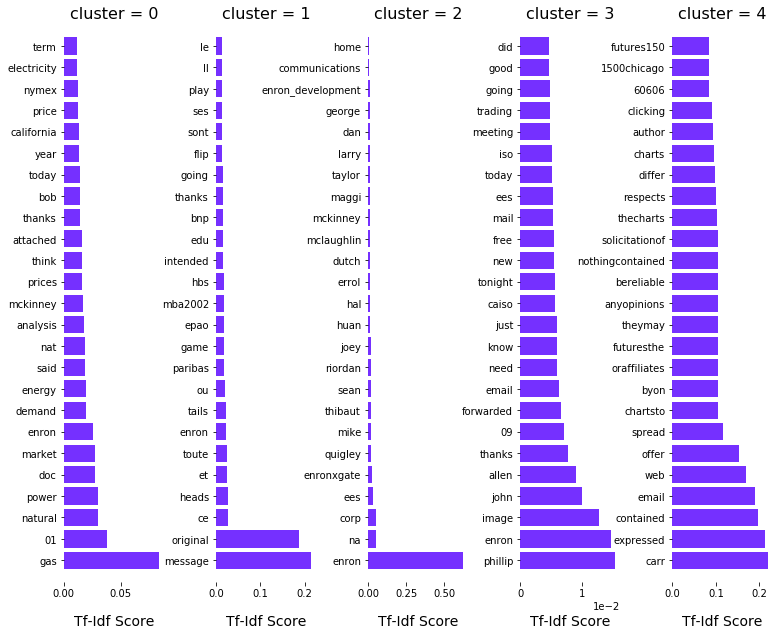

In [15]:
plot_tfidf_classfeats_h(top_feats_per_cluster(X, labels, features, 0.1, 25))


In [16]:
# As clustering algorithm KMeams is a perfect fit.
n_clusters = 3
clf = KMeans(n_clusters=n_clusters, 
            max_iter=100, 
            init='k-means++', 
            n_init=1)
labels = clf.fit_predict(X)

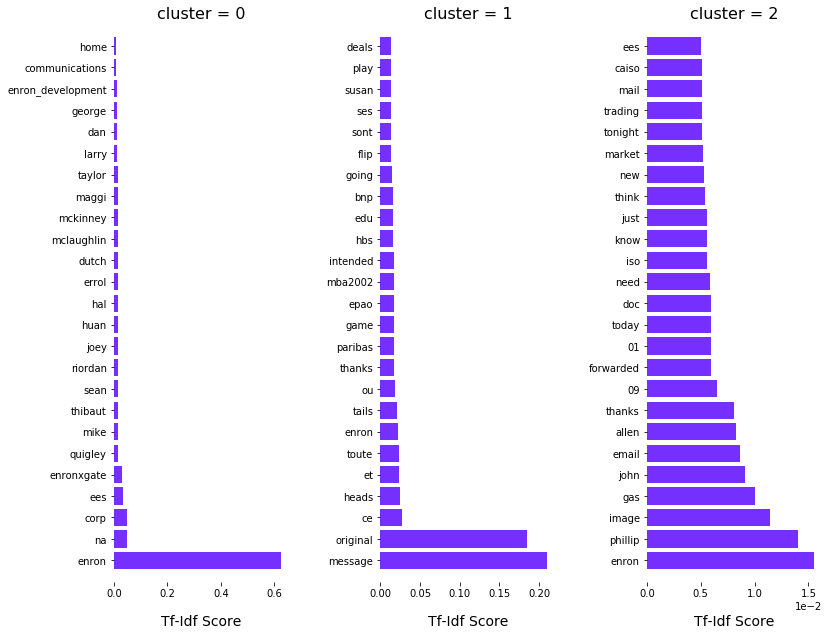

In [17]:
plot_tfidf_classfeats_h(top_feats_per_cluster(X, labels, features, 0.1, 25))


Reading mails from directory 

In [18]:
def read_email_bodies():
  emails = pd.read_csv('E://data//split_emails.csv')
  email_df = pd.DataFrame(parse_into_emails(emails.message))
  email_df.drop(email_df.query("body == '' | to == '' | from_ == ''").index, inplace=True)
  email_df.drop_duplicates(inplace=True)
  return email_df['body']


class EmailDataset: 
  def __init__(self):
    stopwords = ENGLISH_STOP_WORDS.union(['ect', 'hou', 'com', 'recipient'])
    self.vec = TfidfVectorizer(analyzer='word', stop_words=stopwords, max_df=0.3, min_df=2)
    self.emails = read_email_bodies() 

    # train on the given email data.
    self.train()
  
  def train(self):
    self.vec_train = self.vec.fit_transform(self.emails)
  
  def query(self, keyword, limit):
    vec_keyword = self.vec.transform([keyword])
    cosine_sim = linear_kernel(vec_keyword, self.vec_train).flatten()
    related_email_indices = cosine_sim.argsort()[:-limit:-1]
    #print(related_email_indices)
    return related_email_indices

  def find_email_by_index(self, i):
    return self.emails.as_matrix()[i]

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.metrics.pairwise import linear_kernel
import pandas as pd



# Just like in part_1, read and preprocess emails
emails = pd.read_csv('E://data//split_emails.csv') 
email_df = pd.DataFrame(parse_into_emails(emails.message))
email_df.drop(email_df.query("body == '' | to == '' | from_ == ''").index, inplace=True)

stopwords = ENGLISH_STOP_WORDS.union(['ect', 'hou', 'com', 'recipient'])
vec = TfidfVectorizer(analyzer='word', stop_words=stopwords, max_df=0.3, min_df=2)
vec_train = vec.fit_transform(email_df.body)

# print out the vector of the first email
print(vec_train[0:1])

# Find cosine similarity between the first email and all others.
cosine_sim = linear_kernel(vec_train[0:1], vec_train).flatten()
# print out the cosine similarities
print(cosine_sim)



  (0, 16969)	1.0
[1. 0. 0. ... 0. 0. 0.]


In [20]:
# Finding emails related to a query.
query = input()

# Transform the query into the original vector
vec_query = vec.transform([query])

cosine_sim = linear_kernel(vec_query, vec_train).flatten()

# Find top 10 most related emails to the query.
related_email_indices = cosine_sim.argsort()[:-11:-1]
# print out the indices of the 10 most related emails.
print(related_email_indices)

# print out the first email 
#first_email_index = related_email_indices[0]
for i in range(5):
    print(i+1,email_df.body.as_matrix()[related_email_indices[i]])

    
#print(email_df.body.as_matrix()[first_email_index])


john
[2162 5900 5839 6133 5570 7483 4707 3604 5549 7526]
1 John,Do you still want to get together this week?Phillip
2 mike.grigsby@enron.com, john.lavorato@enron.com*~*~*~*~*~*~*~*~*~*John LavoratoJohn ArnoldScott NealTom MartinMike Grigsby
3 Here are the positions that you requested from John.
4 Looks fine to me.--John-----Original Message-----John/Kevin/John --Can you take a look at this and tell me if anything gives you heartburn.  Its a sidebar for an article on energy trading in Global Finance.  The reporter's deadline is Fri., June 8.  Thanks.Eric
5 drinks at your place before?john


C:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [21]:

# use the EmailDataset class to query for keywords.
ds = EmailDataset()
results = ds.query('salary', 10)

# Print out the first result.
print(ds.find_email_by_index(results[0]))


trueJeanie Slonetrue or false-John Griffith should be moved into your cost center with thesame salary, same title effective Feb. 01.


C:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [22]:
n=int(input('Enter the number of query terms on the basis of which you want to categorize mails'))
dic={}
for i in range(n):
    li=[]
    s=input()
    results = ds.query(s, 11)
    for j in range(2):
        li.append(ds.find_email_by_index(results[j]))
    dic[s]=li
print(dic)
    

Enter the number of query terms on the basis of which you want to categorize mails2
john


C:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


salary
{'john': ['John,Do you still want to get together this week?Phillip', 'The EconomistEnergy Risk ManagementHavard Business ReviewThanks,John'], 'salary': ['trueJeanie Slonetrue or false-John Griffith should be moved into your cost center with thesame salary, same title effective Feb. 01.', 'Randy,Can you send me a schedule of the salary and level of everyone in thescheduling group.  Plus your thoughts on any changes that need to be made.(Patti S for example)Phillip']}
